## TODO

- Are there N/C terminal regexes that are not matching correctly?
- Do I require each isoform has at least one PPI?
- vizualize motifs

In [1]:
import re

import numpy as np
import pandas as pd

from ccsblib import huri

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_valid_isoform_clones,
                          load_annotated_6k_collection)

pd.set_option('display.max_columns', 100)

In [2]:
pfam = huri.load_pfam_domains()
dlm = pd.read_csv('../../data/external/elm_interaction_domains.tsv',
                  sep='\t')
elm = pd.read_csv('../../data/external/elm_classes.tsv', header=0, comment='#', sep='\t')
orfs_with_slim_dom = pfam.loc[pfam['pfam_accession'].isin(dlm['Interaction Domain Id']),
                              'orf_id'].unique()
ppi = load_isoform_and_paralog_y2h_data()
ppi = ppi.loc[ppi['category'] == 'tf_isoform_ppis', :]
ppi['gene_level_pair'] = ppi['ad_gene_symbol'] + '_' + ppi['db_gene_symbol']
ppi['ad_iso_id'] = ppi['ad_clone_acc'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])
# dropping gene with insertion relative to reference geneome
ppi = ppi.loc[~(ppi['ad_gene_symbol'] == 'PCGF6'), :]
iso = load_valid_isoform_clones()
iso = iso.set_index('clone_acc')
tfs = load_annotated_6k_collection()

Saving time


In [3]:
print(ppi.loc[:, ['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0],
      'gene level PPIs')
print(ppi.loc[ppi['db_orf_id'].isin(orfs_with_slim_dom),
              ['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0],
      'gene level PPIs involving motif binding domain')

1825 gene level PPIs
511 gene level PPIs involving motif binding domain


In [4]:
dom_slim_ppi = set(ppi.loc[ppi['db_orf_id'].isin(orfs_with_slim_dom),
                       'gene_level_pair'].unique())
pos_ppi = set(ppi.loc[(ppi['score'] == '1'), 'gene_level_pair'].unique())
neg_ppi = set(ppi.loc[(ppi['score'] == '0'), 'gene_level_pair'].unique())
diff_slim_ppi = dom_slim_ppi.intersection(pos_ppi.intersection(neg_ppi))
print(len(diff_slim_ppi), 
      'gene-level PPIs where partner has SLiM binding domain and some isoforms bind and some dont')
print('involving {} TF genes'.format(len({p.split('_')[0] for p in diff_slim_ppi})))

212 gene-level PPIs where partner has SLiM binding domain and some isoforms bind and some dont
involving 56 TF genes


In [5]:
def match_elm_motifs(orfs, elm):
    """Take the ELM motifs file and match the regex to given aa seqs
    Args:
        orfs (Series): amino acid sequences indexed by ORF ID
    Returns:
        DataFrame: one row for each seperate match of a motif to an ORF
    """
    motifs = []
    for elmIdx, elmRow in elm.iterrows():
        # inserting ?: to make groups non-capture
        motifMatches = orfs.str.findall(elmRow['Regex'].replace('(', '(?:'))
        for orfID, matches in zip(motifMatches.index, motifMatches.values):
            for match in matches:
                start = orfs.loc[orfID].find(match)
                # switch from 0 to 1-based indexing
                motifs.append((orfID,
                               elmRow['Accession'],
                               elmRow['ELMIdentifier'],
                               start + 1,
                               start + len(match)))
    motifs = pd.DataFrame(data=motifs,
                          columns=('orf_id', 'region_id', 'ELM_ID', 'start', 'end'))
    motifs['source'] = 'ELM_prediction'
    motifs['type'] = 'SLiM'
    return motifs


slims = match_elm_motifs(iso['aa_seq'], elm)

In [6]:
def isoform_specific_regions(gene_name):
    """The name is a bit misleading because it's not specific to one isoform but just
       not common to all isoforms.

    Returns: dict(frozenset: list(str)): isoform IDs and list of contiguous AA sequences
                                         that map to them only 

    """
    if gene_name not in tfs:
        raise UserWarning(gene_name + ' not found')
    algn = tfs[gene_name].genomic_alignment_of_aa_seqs()
    subset_prev = None
    isr = {}
    len_algn = len(list(algn.values())[0])
    for i in range(len_algn):
        subset = frozenset({k for k, v in algn.items() if v[i] != '-'})
        if subset_prev is None:
            if (len(subset) < len(algn)) and (len(subset) > 0):
                start = i
                subset_prev = subset
        else:
            if subset != subset_prev or i == len_algn - 1:
                if (len(subset_prev) < len(algn)) and (len(subset_prev) > 0):
                    subseq = (algn[list(subset_prev)[0]][start:i], start, i)
                    isr[subset_prev] = isr.get(subset_prev, []) + [subseq]
                start = i
                subset_prev = subset
    merged = {}
    for iso_subset, subseqs in isr.items():
        merged[iso_subset] = []
        prev_end = np.inf
        prev_subseq = ''
        for subseq, start, end in subseqs:
            if start <= prev_end + 2:
                prev_subseq += subseq
                prev_end = end
            else:
                if prev_subseq != '':
                    merged[iso_subset].append(prev_subseq)
                prev_subseq = subseq
                prev_end = end
        merged[iso_subset].append(prev_subseq)
    merged
    return merged


def ppi_tf_gene(data, gene_name):
    tf = data.loc[(data['category'] == 'tf_isoform_ppis') &
                (data['ad_gene_symbol'] == gene_name),
                ['ad_iso_id', 'db_gene_symbol', 'score']].copy()
    tf['score'] = tf['score'].map({'1': True,
                               '0': False,
                               'AA': np.nan,
                               'NC': np.nan})
    tf = tf.pivot(index='ad_iso_id',
                  columns='db_gene_symbol',
                  values='score')
    return tf


def ppi_linked_isoform_specific_regions(ppi_data, gene_name):
    """
    For now, do not use cases where there are missing values
    """
    isr = isoform_specific_regions(gene_name)
    ppi = ppi_tf_gene(ppi_data, gene_name)
    ppi_isr = {}
    ppi_iso = {partner: set(ppi.index[ppi[partner]])
               for partner in ppi.columns
               if ppi[partner].notnull().all()}
    for partner, ppi_iso_subset in ppi_iso.items():
        for isr_subset, aa_seqs in isr.items():
            if ppi_iso_subset == isr_subset:
                ppi_isr[partner] = (isr_subset, aa_seqs)
    return ppi_isr

In [7]:
slim_binding_domains = pd.merge(pfam,
                                dlm,
                                how='inner',
                                left_on='pfam_accession',
                                right_on='Interaction Domain Id')
slim_binding_domains = pd.merge(slim_binding_domains,
                                ppi,
                                how='inner',
                                left_on='orf_id',
                                right_on='db_orf_id')
slim_ppis = slim_binding_domains.loc[:, ['ad_gene_symbol', 
                                        'db_gene_symbol',
                                        'pfam_accession',
                                        'domain_name',
                                        'domain_description',
                                        'ELM identifier']].drop_duplicates()
ppi_isr = {}
for gene_name in slim_ppis['ad_gene_symbol'].unique():
    ppi_isr[gene_name] = ppi_linked_isoform_specific_regions(ppi, gene_name)
slim_ppis = slim_ppis.loc[slim_ppis.apply(lambda x: x['db_gene_symbol'] in ppi_isr[x    ['ad_gene_symbol']],
                              axis=1),
              :]
slim_ppis['aa_seq_isr'] = slim_ppis.apply(lambda x: ppi_isr[x['ad_gene_symbol']][x['db_gene_symbol']][1], axis=1)

In [8]:
def isr_contains_slim(row):
    # inserting ?: to make groups non-capture
    if row['ELM identifier'] not in elm['ELMIdentifier'].values:
        #raise UserWarning('Missing ELM entry for: ', row['ELM identifier'])
        print('Missing ELM entry for: ', row['ELM identifier'])
        return False
    regex = elm.loc[elm['ELMIdentifier'] == row['ELM identifier'], 'Regex'].values[0].replace('(', '(?:')
    return any(bool(re.search(regex, aa_seq)) for aa_seq in row['aa_seq_isr'])


slim_ppis['slim_match'] = slim_ppis.apply(isr_contains_slim, axis=1)

Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  LIG_CaM_1-26_7
Missing ELM entry for:  LIG_CaM_1-17_6
Missing ELM entry for:  LIG_CaM_1-8-9-10_5
Missing ELM entry for:  LIG_CaM_1-8-14_4
Missing ELM entry for:  LIG_CaM_1-5-10-14_3
Missing ELM entry for:  LIG_CaM_1-8_REV_2
Missing ELM entry for:  LIG_CaM_1-14-15-16_REV_1
Missing ELM entry for:  LIG_CaM_1-26_7
Missing ELM entry for:  LIG_CaM_1-17_6
Missing ELM entry for:  LIG_CaM_1-8-9-10_5
Missing ELM entry for:  LIG_CaM_1-8-14_4
Missing ELM entry for:  LIG_CaM_1-5-10-14_3
Missing ELM entry for:  LIG_CaM_1-8_REV_2
Missing ELM entry for:  LIG_CaM_1-14-15-16_REV_1
Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  MOD_PLK
Missing ELM entry for:  MOD_PLK
Missing ELM entry for:

In [9]:
# count inside region, count outside region...
slim_ppis['aa_seq_ref_iso'] = slim_ppis['ad_gene_symbol'].apply(lambda x: tfs[x].orfs[0].aa_seq)
slim_ppis['regex'] = slim_ppis['ELM identifier'].map(elm[['ELMIdentifier', 'Regex']]
                                                        .drop_duplicates()
                                                        .set_index('ELMIdentifier')
                                                        ['Regex'].str.replace('(', '(?:'))
# TODO: fix missing regex.
#       Difficult because they don't appear on the website
#       or in the list of (e.g. MOD_PLK). I should email
#       the ELM people.
slim_ppis = slim_ppis.dropna(subset=['regex'])
slim_ppis['match_count_ref_iso'] = slim_ppis.apply(lambda x: len(re.findall(x['regex'], x['aa_seq_ref_iso'])),
                axis=1)
slim_ppis['match_count_isr'] = slim_ppis.apply(lambda x: sum(len(re.findall(x['regex'], s)) for s in x['aa_seq_isr']),
                axis=1)
slim_ppis['aa_seq_len_ref_iso'] = slim_ppis['aa_seq_ref_iso'].str.len()
slim_ppis['isr_len'] = slim_ppis['aa_seq_isr'].apply(lambda x: sum(len(s) for s in x))
slim_ppis['motif_probability'] = slim_ppis['ELM identifier'].map(elm.set_index('ELMIdentifier')['Probability'])

In [53]:
slim_ppis.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_isr'].sum().head(30)

ad_gene_symbol  db_gene_symbol
ATF2            MAPK9              7
CREB5           MAPK9             20
CREBZF          HCFC1              1
                RALBP1             0
ESRRA           VAX1               0
ESRRG           NR0B2              0
FOS             PIN1               4
FOSB            HOMER3             2
                PRKAA2            14
FOXJ2           CSTF2T             0
FOXN4           HOXC8              0
                PIN1               3
                PRKAA2            15
FOXP2           CTBP2              1
                LNX1               1
                PIN1               7
                RNF8               3
                SDCBP              1
HMBOX1          ASB7               0
                CDK18              2
                UBE2Z              1
                VAX1               0
HOXA1           PCSK5             10
IKZF2           ARHGEF5            0
                CDC7               5
                CTBP2              0
       

In [16]:
# per ISR / domain, how many get a match
(slim_ppis.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_isr'].sum() > 0).value_counts()

False    88
True     38
Name: match_count_isr, dtype: int64

In [54]:
slim_ppis.head()

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match,aa_seq_ref_iso,regex,match_count_ref_iso,match_count_isr,aa_seq_len_ref_iso,isr_len
0,TCF4,KLC3,PF00515,TPR_1,Tetratricopeptide repeat,LIG_TPR,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHF...,False,MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFT...,EEVD$,0,0,671,129
8,TCF4,KLC3,PF00515,TPR_1,Tetratricopeptide repeat,TRG_PTS1,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHF...,False,MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFT...,(?:.[SAPTC][KRH][LMFI]$)|(?:[KRH][SAPTC][NTS][...,0,0,671,129
16,TCF4,KLC3,PF00515,TPR_1,Tetratricopeptide repeat,LIG_APCC_Cbox_2,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHF...,False,MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFT...,DR[YFH][ILFVM][PA]..,0,0,671,129
24,TCF4,KLC3,PF00515,TPR_1,Tetratricopeptide repeat,LIG_APCC_Cbox_1,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHF...,False,MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFT...,[DE]R[YFH][ILFVM][PAG].R,0,0,671,129
545,TCF4,BARHL2,PF00046,Homeobox,Homeobox domain,LIG_HOMEOBOX,[MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHF...,False,MHHQQRMAALGTDKELSDLLDFSAMFSPPVSSGKNGPTSLASGHFT...,[FY][DEP]WM,0,0,671,129


In [64]:
# for each gene-gene pair, pick random sequence on longest isoform of length of ISR and look for match
gg = slim_ppis.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'aa_seq_ref_iso', 'isr_len']].drop_duplicates().copy().set_index(['ad_gene_symbol', 'db_gene_symbol'])

def rand_subseq(row):
    rand_start = np.random.randint((len(row['aa_seq_ref_iso']) - row['isr_len']) + 1)
    return row['aa_seq_ref_iso'][rand_start:rand_start + row['isr_len']]

null_dist = []
n_samples = 100
for __ in range(n_samples):
    rand_seq = gg.apply(rand_subseq, axis=1)
    rand_seq = pd.merge(rand_seq.rename('rand_aa_seq').reset_index(),
                        slim_ppis.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'regex']],
                        how='inner')
    rand_seq['match_count_rand_aa_seq'] = rand_seq.apply(lambda x: len(re.findall(x['regex'], x['rand_aa_seq'])),
                    axis=1)
    null_dist.append((rand_seq.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_rand_aa_seq'].sum() > 0).sum())
real = (slim_ppis.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_isr'].sum() > 0).sum()
n = slim_ppis[['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0]
print('real =', real, 'out of', n)
print('P =', len([n for n in null_dist if n >= real]) / n_samples)

real =  38 out of 126
P = 0.111


In [66]:
# trying same thing using most specific regex
slim_ppis_spec = slim_ppis.sort_values('motif_probability', ascending=True).drop_duplicates(['ad_gene_symbol', 'db_gene_symbol', 'pfam_accession']).copy()

In [67]:
gg = slim_ppis_spec.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'aa_seq_ref_iso', 'isr_len']].drop_duplicates().copy().set_index(['ad_gene_symbol', 'db_gene_symbol'])

def rand_subseq(row):
    rand_start = np.random.randint((len(row['aa_seq_ref_iso']) - row['isr_len']) + 1)
    return row['aa_seq_ref_iso'][rand_start:rand_start + row['isr_len']]

null_dist = []
n_samples = 100
for __ in range(n_samples):
    rand_seq = gg.apply(rand_subseq, axis=1)
    rand_seq = pd.merge(rand_seq.rename('rand_aa_seq').reset_index(),
                        slim_ppis_spec.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'regex']],
                        how='inner')
    rand_seq['match_count_rand_aa_seq'] = rand_seq.apply(lambda x: len(re.findall(x['regex'], x['rand_aa_seq'])),
                    axis=1)
    null_dist.append((rand_seq.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_rand_aa_seq'].sum() > 0).sum())
real = (slim_ppis_spec.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_isr'].sum() > 0).sum()
n = slim_ppis_spec[['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0]
print('real = ', real, 'out of', n)
print('P =', len([n for n in null_dist if n >= real]) / n_samples)

real =  8 out of 126
P = 0.019


In [72]:
slim_ppis['isr_frac'] = (slim_ppis['isr_len'] / slim_ppis['aa_seq_len_ref_iso'])

In [78]:
(slim_ppis[['ad_gene_symbol', 'db_gene_symbol', 'isr_frac']].drop_duplicates()['isr_frac'] < 0.2).sum()

66

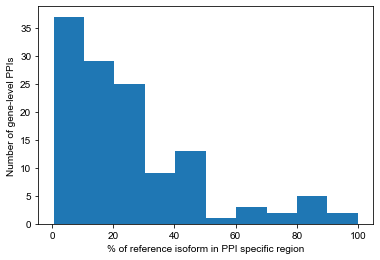

In [99]:
from matplotlib import pyplot as plt
(slim_ppis.loc[: ,['ad_gene_symbol', 'db_gene_symbol', 'isr_frac']].drop_duplicates()['isr_frac'] * 100).plot.hist()
plt.xlabel('% of reference isoform in PPI specific region')
plt.ylabel('Number of gene-level PPIs')
plt.savefig('../../figures/fraction_isr.pdf', bbox_inches='tight')

In [81]:
slim_ppis_spec = slim_ppis.loc[slim_ppis['isr_frac'] <= 0.1, :].copy()
gg = slim_ppis_spec.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'aa_seq_ref_iso', 'isr_len']].drop_duplicates().copy().set_index(['ad_gene_symbol', 'db_gene_symbol'])

def rand_subseq(row):
    rand_start = np.random.randint((len(row['aa_seq_ref_iso']) - row['isr_len']) + 1)
    return row['aa_seq_ref_iso'][rand_start:rand_start + row['isr_len']]

null_dist = []
n_samples = 100
for __ in range(n_samples):
    rand_seq = gg.apply(rand_subseq, axis=1)
    rand_seq = pd.merge(rand_seq.rename('rand_aa_seq').reset_index(),
                        slim_ppis_spec.loc[:, ['ad_gene_symbol', 'db_gene_symbol', 'regex']],
                        how='inner')
    rand_seq['match_count_rand_aa_seq'] = rand_seq.apply(lambda x: len(re.findall(x['regex'], x['rand_aa_seq'])),
                    axis=1)
    null_dist.append((rand_seq.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_rand_aa_seq'].sum() > 0).sum())
real = (slim_ppis_spec.groupby(['ad_gene_symbol', 'db_gene_symbol'])['match_count_isr'].sum() > 0).sum()
n = slim_ppis_spec[['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0]
print('real = ', real, 'out of', n)
print('P =', len([n for n in null_dist if n >= real]) / n_samples)

real =  6 out of 37
P = 0.99


In [12]:
print(slim_ppis['match_count_ref_iso'].sum())
print(slim_ppis['match_count_isr'].sum())
print(slim_ppis['match_count_ref_iso'].sum() / slim_ppis['aa_seq_len_ref_iso'].sum())
print(slim_ppis['match_count_isr'].sum() / slim_ppis['isr_len'].sum())

1372
358
0.0022695654906942854
0.002524380010859065


In [183]:
res = slim_ppis.sort_values('motif_probability', ascending=True).drop_duplicates(['ad_gene_symbol', 'db_gene_symbol', 'pfam_accession'])
print(res['match_count_ref_iso'].sum() / res['aa_seq_len_ref_iso'].sum())
print(res['match_count_isr'].sum() / res['isr_len'].sum())
print((res['match_count_ref_iso'] - res['match_count_isr']).sum() / (res['aa_seq_len_ref_iso'] - res['isr_len']).sum())
print((slim_ppis.loc[slim_ppis['slim_match'],
               ['ad_gene_symbol', 'db_gene_symbol']]
          .drop_duplicates()
          .shape[0]))

0.00019543973941368078
0.0003751078435050077
0.00012224752066747146


In [83]:
slim_ppis.columns

Index(['ad_gene_symbol', 'db_gene_symbol', 'pfam_accession', 'domain_name',
       'domain_description', 'ELM identifier', 'aa_seq_isr', 'slim_match',
       'aa_seq_ref_iso', 'regex', 'match_count_ref_iso', 'match_count_isr',
       'aa_seq_len_ref_iso', 'isr_len', 'motif_probability', 'isr_frac'],
      dtype='object')

In [91]:
(slim_ppis.loc[slim_ppis['slim_match'], ['ad_gene_symbol', 'db_gene_symbol', 'domain_description', 'ELM identifier', 'regex', 'motif_probability']].sort_values('motif_probability')
.drop_duplicates(['ad_gene_symbol', 'db_gene_symbol', 'domain_description'])).to_csv('~/Desktop/slim_matches.csv', index=False)

In [103]:
match_pairs = (slim_ppis.loc[slim_ppis['slim_match'],
               ['ad_gene_symbol', 'db_gene_symbol']]
                .drop_duplicates())
match_pairs.head()

,ad_gene_symbol,db_gene_symbol
3606,STAT3,BLK
3839,IKZF2,ARHGEF5
3980,PAX5,STAC
4014,MEIS2,HCK
4229,IKZF2,TXK
4406,STAT3,TXK
5483,TCF4,CABP5
6410,FOXP2,RNF8
7162,FOXP2,SDCBP
7525,MEIS2,LNX1


In [125]:
print(match_pairs.shape[0], 'gene-level PPIs corresponding to motif in the isoform regions')
print('out of {} possible'.format(slim_ppis[['ad_gene_symbol', 'db_gene_symbol']].drop_duplicates().shape[0]))

42 gene-level PPIs corresponding to motif in the isoform regions
out of 126 possible


In [104]:
match_pairs['ad_gene_symbol'].value_counts().head()

FOXP2     5
STAT3     3
IKZF2     3
MEIS2     3
ZNF263    2
Name: ad_gene_symbol, dtype: int64

In [119]:
slim_ppis.loc[slim_ppis['ad_gene_symbol'] == 'FOXP2', :]

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match,isr_length,motif_probability
6410,FOXP2,RNF8,PF00498,FHA,FHA domain,LIG_FHA_1,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,True,292,8.662243e-03
6417,FOXP2,RNF8,PF00498,FHA,FHA domain,LIG_FHA_2,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,True,292,8.286441e-03
7084,FOXP2,SDCBP,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_1,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,False,292,7.254532e-05
7123,FOXP2,SDCBP,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_2,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,False,292,7.888516e-05
7162,FOXP2,SDCBP,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_3,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,True,292,6.168209e-05
7201,FOXP2,SDCBP,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_FZD_DVL_PDZ,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,False,292,8.742688e-09
7240,FOXP2,SDCBP,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Wminus1_1,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,False,292,3.717553e-06
7478,FOXP2,LNX1,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_1,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,False,292,7.254532e-05
7515,FOXP2,LNX1,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_2,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,False,292,7.888516e-05
7552,FOXP2,LNX1,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_3,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,True,292,6.168209e-05


In [105]:
match_pairs['db_gene_symbol'].value_counts().head()

PIN1      5
PRKAA2    3
LNX1      2
MAPK9     2
TXK       2
Name: db_gene_symbol, dtype: int64

In [106]:
slim_ppis.loc[slim_ppis['slim_match'] & (slim_ppis['db_gene_symbol'] == 'PIN1'), :]

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match
23472,FOXN4,PIN1,PF00397,WW,WW domain,DOC_WW_Pin1_4,[MIESDTSSIMSGIIRNSGQNHHPSPQEYRLLATTSDDDLPGDLQS...,True
23474,PBX1,PIN1,PF00397,WW,WW domain,DOC_WW_Pin1_4,[GSSSSFNMSNSGDLFMSVQSLNGDSYQGAQVGANVQSQVDTLRHV...,True
23477,FOXP2,PIN1,PF00397,WW,WW domain,DOC_WW_Pin1_4,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,True
23496,FOS,PIN1,PF00397,WW,WW domain,DOC_WW_Pin1_4,[MAAAKCRNRRRELTDTLQAETDQLEDEKSALQTEIANLLKEKEKL...,True
23504,MEOX1,PIN1,PF00397,WW,WW domain,DOC_WW_Pin1_4,[MDPAASSCMRSLQPPAPVWGCLRNPHSEGNGASGLPHYPPTPFSF...,True


Pin1 Links the Activities of c-Abl
and p300 in Regulating p73 Function, Mol. Cell, 2004

It has been showing that TP73 isoforms lacking the PIN1 interacting motif have reduced transcriptional activity.

Also the mouse FOS has the PIN1 motif binding shown.

In [107]:
ppi.loc[ppi['db_gene_symbol'] == 'PIN1',
        'ad_gene_symbol'].nunique()
ppi.loc[ppi['db_gene_symbol'] == 'PIN1',
        'ad_gene_symbol'].unique()

array(['FOXN4', 'GLI1', 'PBX1', 'TCF4', 'FOXP2', 'TCF12', 'TP63', 'ETV6',
       'HOMEZ', 'ZBTB7B', 'FOS', 'RELA', 'ZNF784', 'GATA1', 'MEOX1',
       'ZNF212'], dtype=object)

In [109]:
# smallest region
slim_ppis['isr_length'] = slim_ppis['aa_seq_isr'].apply(lambda x: min(len(s) for s in x))
(slim_ppis.loc[slim_ppis['slim_match'], :]
          .sort_values('isr_length')
          .drop_duplicates(['ad_gene_symbol', 'db_gene_symbol', 'pfam_accession'])
          .head(30))

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match,isr_length
15936,TCF12,NEK6,PF00069,Pkinase,Protein kinase domain,MOD_GSK3_1,[SEVTLLRNEVAQLKQLLLAHKDCPVTAMQKKSGYHTADKDDSSED...,True,1
21206,NFYA,PRKAA2,PF00069,Pkinase,Protein kinase domain,MOD_Plk_2-3,[SEVTLLRNEVAQLKQLLLAHKDCPVTAMQKKSGYHTADKDDSSED...,True,1
14019,TCF12,EPHB6,PF00069,Pkinase,Protein kinase domain,MOD_Plk_4,[KNRVEQQLHEHLQDAMSFLKDVCE],True,24
4411,IKZF2,TXK,PF00069,Pkinase,Protein kinase domain,MOD_CK2_1,[SEVTLLRNEVAQLKQLLLAHKDCPVTAMQKKSGYHTADKDDSSED...,True,26
3839,IKZF2,ARHGEF5,PF00018,SH3_1,SH3 domain,LIG_SH3_3,[SEVTLLRNEVAQLKQLLLAHKDCPVTAMQKKSGYHTADKDDSSED...,True,26
4229,IKZF2,TXK,PF00018,SH3_1,SH3 domain,LIG_SH3_3,[SEVTLLRNEVAQLKQLLLAHKDCPVTAMQKKSGYHTADKDDSSED...,True,26
18378,ATF2,MAPK9,PF00069,Pkinase,Protein kinase domain,MOD_PK_1,[RFTNEDHLAVHKHKHEMTLKFGPARNDSVIVA],True,32
23956,HMBOX1,UBE2Z,PF00179,UQ_con,Ubiquitin-conjugating enzyme,MOD_SUMO_for_1,[DDSTSHSDHQDPISLAVEMAAVNHTILALARQGANEIKTEALDD],True,44
15855,HMBOX1,CDK18,PF00069,Pkinase,Protein kinase domain,MOD_Plk_4,[DDSTSHSDHQDPISLAVEMAAVNHTILALARQGANEIKTEALDD],True,44
14643,IKZF2,CDC7,PF00069,Pkinase,Protein kinase domain,MOD_ProDKin_1,[VPPMEDCKEQEPIMDNNISLVPFERPAVIEKLTGNMGKRKSSTPQ...,True,48


In [111]:
# most specific regex
(slim_ppis.loc[slim_ppis['slim_match'], :]
          .sort_values('motif_probability')
          .drop_duplicates(['ad_gene_symbol', 'db_gene_symbol', 'pfam_accession'])
          .head(30))

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match,isr_length,motif_probability
22605,CREBZF,HCFC1,PF13415,Kelch_3,"Galactose oxidase, central domain",LIG_HCF-1_HBM_1,[MRHSLTKLLAASGSNSPTRSESPEPAATCSLPSDLTRAAAGEEET...,True,354,0.000051
7162,FOXP2,SDCBP,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_3,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,True,292,0.000062
7552,FOXP2,LNX1,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_3,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,True,292,0.000062
24094,NFIX,MLH1,PF16413,Mlh1_C,DNA mismatch repair protein Mlh1 C-terminus,LIG_MLH1_MIPbox_1,[GSPRATASALHFPSTSIIQQSSPYFTHPTIRYHHHHGQDSLKEFV...,True,82,0.000062
8254,MEIS2,IL16,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_2,[SEVTLLRNEVAQLKQLLLAHKDCPVTAMQKKSGYHTADKDDSSED...,True,94,0.000079
7525,MEIS2,LNX1,PF00595,PDZ,PDZ domain (Also known as DHR or GLGF),LIG_PDZ_Class_2,[SEVTLLRNEVAQLKQLLLAHKDCPVTAMQKKSGYHTADKDDSSED...,True,94,0.000079
16874,ZNF263,CLK3,PF00069,Pkinase,Protein kinase domain,DOC_MAPK_HePTP_8,[VTNHGRGTEVLLEEPLPLETARESPSFKLEPMETERSPGPRLQEL...,True,553,0.000107
19582,ZNF263,CLK2,PF00069,Pkinase,Protein kinase domain,DOC_MAPK_HePTP_8,[VTNHGRGTEVLLEEPLPLETARESPSFKLEPMETERSPGPRLQEL...,True,553,0.000107
24139,FOXP2,CTBP2,PF00389,2-Hacid_dh,"D-isomer specific 2-hydroxyacid dehydrogenase,...",LIG_CtBP_PxDLS_1,[LNLVSSVTMSKNMLETSPQSLPQTPTTPTAPVTPITQGPSVITPA...,True,292,0.000117
24155,SOX5,CTBP2,PF00389,2-Hacid_dh,"D-isomer specific 2-hydroxyacid dehydrogenase,...",LIG_CtBP_PxDLS_1,[MSVMSSKRPASPYGEADGEVAMVTSRQKVEEEESDGLPAFHLPLH...,True,378,0.000117


In [112]:
slim_ppis.loc[slim_ppis['slim_match'] & (slim_ppis['ad_gene_symbol'] == 'STAT3'), :]

,ad_gene_symbol,db_gene_symbol,pfam_accession,domain_name,domain_description,ELM identifier,aa_seq_isr,slim_match,isr_length,motif_probability
3606,STAT3,BLK,PF00018,SH3_1,SH3 domain,LIG_SH3_3,[TTCSNTIDLPMSPRTLDSLMQFGNNGEGAEPSAGGQFESLTFDME...,True,54,0.013173
3630,STAT3,BLK,PF00069,Pkinase,Protein kinase domain,MOD_CK1_1,[TTCSNTIDLPMSPRTLDSLMQFGNNGEGAEPSAGGQFESLTFDME...,True,54,0.017041
3636,STAT3,BLK,PF00069,Pkinase,Protein kinase domain,MOD_GSK3_1,[TTCSNTIDLPMSPRTLDSLMQFGNNGEGAEPSAGGQFESLTFDME...,True,54,0.026787
3669,STAT3,BLK,PF00069,Pkinase,Protein kinase domain,MOD_ProDKin_1,[TTCSNTIDLPMSPRTLDSLMQFGNNGEGAEPSAGGQFESLTFDME...,True,54,0.015433
3702,STAT3,BLK,PF00069,Pkinase,Protein kinase domain,MOD_CDK_SPK_2,[TTCSNTIDLPMSPRTLDSLMQFGNNGEGAEPSAGGQFESLTFDME...,True,54,0.001929
3717,STAT3,BLK,PF00069,Pkinase,Protein kinase domain,MOD_Plk_4,[TTCSNTIDLPMSPRTLDSLMQFGNNGEGAEPSAGGQFESLTFDME...,True,54,0.006019
3723,STAT3,BLK,PF00069,Pkinase,Protein kinase domain,MOD_Plk_2-3,[TTCSNTIDLPMSPRTLDSLMQFGNNGEGAEPSAGGQFESLTFDME...,True,54,0.002175
4406,STAT3,TXK,PF00069,Pkinase,Protein kinase domain,MOD_CK1_1,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAY...,True,98,0.017041
4601,STAT3,TXK,PF00069,Pkinase,Protein kinase domain,MOD_NEK2_1,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAY...,True,98,0.009798
4783,STAT3,TXK,PF00069,Pkinase,Protein kinase domain,MOD_Plk_4,[MAQWNQLQQLDTRYLEQLHQLYSDSFPMELRQFLAPWIESQDWAY...,True,98,0.006019
